<a href="https://colab.research.google.com/github/nirajlondhe8/aiml/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

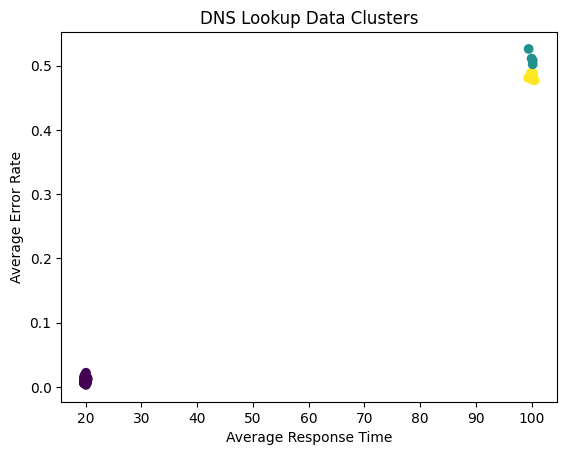

Anomaly Clusters: [1, 2]


In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Synthetic Data Generation

# Define parameters for synthetic data
num_domains = 100
num_queries_per_domain = 1000
normal_response_time_mean = 20
normal_response_time_std = 5
anomaly_response_time_mean = 100
anomaly_response_time_std = 10
normal_error_rate = 0.01
anomaly_error_rate = 0.5

# Generate synthetic data
data = []
for i in range(num_domains):
    # Normal behavior
    response_times = np.random.normal(normal_response_time_mean, normal_response_time_std, num_queries_per_domain)
    errors = np.random.binomial(1, normal_error_rate, num_queries_per_domain)

    # Introduce anomalies in a subset of domains
    if i % 10 == 0:  # Anomalies in every 10th domain
        response_times = np.random.normal(anomaly_response_time_mean, anomaly_response_time_std, num_queries_per_domain)
        errors = np.random.binomial(1, anomaly_error_rate, num_queries_per_domain)

    # Create a DataFrame for each domain
    domain_data = pd.DataFrame({
        'domain_id': i,
        'response_time': response_times,
        'error_rate': errors
    })
    data.append(domain_data)

# Concatenate data for all domains
data = pd.concat(data, ignore_index=True)

# 2. Data Preprocessing

# Calculate average response time and error rate per domain
data_agg = data.groupby('domain_id').agg({'response_time': 'mean', 'error_rate': 'mean'}).reset_index()

# Standardize features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_agg[['response_time', 'error_rate']])

# 3. K-Means Clustering

# Choose the number of clusters (e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the data
data_agg['cluster'] = kmeans.labels_

# 4. Anomaly Detection

# Calculate cluster statistics
cluster_stats = data_agg.groupby('cluster').agg({'response_time': ['mean', 'std'], 'error_rate': ['mean', 'std']})

# Identify clusters with potential anomalies
anomaly_clusters = []
for cluster_id, stats in cluster_stats.iterrows():
    if stats[('response_time', 'mean')] > (normal_response_time_mean + 2 * normal_response_time_std) or \
       stats[('error_rate', 'mean')] > (normal_error_rate + 2 * normal_error_rate):
        anomaly_clusters.append(cluster_id)

# 5. Visualization

# Visualize clusters in 2D space
plt.scatter(data_agg['response_time'], data_agg['error_rate'], c=data_agg['cluster'], cmap='viridis')
plt.xlabel('Average Response Time')
plt.ylabel('Average Error Rate')
plt.title('DNS Lookup Data Clusters')
plt.show()

# Print anomaly clusters
print("Anomaly Clusters:", anomaly_clusters)

# 6. Further Analysis

# Investigate domains within anomaly clusters in more detail.
# Analyze individual query logs for these domains to understand the root cause of anomalies.
# Consider using other clustering algorithms or anomaly detection techniques for more robust analysis.


In [2]:
# 6. Further Analysis

# Investigate domains within anomaly clusters
for cluster_id in anomaly_clusters:
    anomaly_domains = data_agg[data_agg['cluster'] == cluster_id]['domain_id'].tolist()
    print(f"Anomaly Cluster {cluster_id}:")
    print("Affected Domains:", anomaly_domains)

    # Analyze individual query logs (assuming you have detailed query log data)
    for domain_id in anomaly_domains:
        domain_logs = data[data['domain_id'] == domain_id]
        print(f"Domain {domain_id}:")
        print(" - Average Response Time:", domain_logs['response_time'].mean())
        print(" - Error Rate:", domain_logs['error_rate'].mean())
        # Further analysis of individual query logs can include:
        # - Time series analysis to identify temporal patterns (e.g., spikes in errors)
        # - Source IP analysis to pinpoint the origin of problematic queries
        # - Query type analysis to determine if specific record types are more affected

# Consider using other clustering algorithms or anomaly detection techniques

from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

# DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
dbscan_labels = dbscan.fit_predict(scaled_data)
data_agg['dbscan_cluster'] = dbscan_labels

# Isolation Forest
isolation_forest = IsolationForest(contamination=0.1)  # Adjust contamination level as needed
isolation_forest_scores = isolation_forest.fit_predict(scaled_data)
data_agg['isolation_forest_score'] = isolation_forest_scores

# Analyze results from alternative methods
# ...

Anomaly Cluster 1:
Affected Domains: [30, 70, 80, 90]
Domain 30:
 - Average Response Time: 99.48727235966398
 - Error Rate: 0.526
Domain 70:
 - Average Response Time: 100.22653671571179
 - Error Rate: 0.508
Domain 80:
 - Average Response Time: 100.20799720740293
 - Error Rate: 0.502
Domain 90:
 - Average Response Time: 100.0124734783402
 - Error Rate: 0.511
Anomaly Cluster 2:
Affected Domains: [0, 10, 20, 40, 50, 60]
Domain 0:
 - Average Response Time: 100.17884364942745
 - Error Rate: 0.478
Domain 10:
 - Average Response Time: 100.22877202232429
 - Error Rate: 0.485
Domain 20:
 - Average Response Time: 100.57495840226025
 - Error Rate: 0.477
Domain 40:
 - Average Response Time: 100.30008630064562
 - Error Rate: 0.488
Domain 50:
 - Average Response Time: 99.89394160776897
 - Error Rate: 0.489
Domain 60:
 - Average Response Time: 99.38261131623776
 - Error Rate: 0.481



DBSCAN Analysis:
DBSCAN Cluster 0:
 - Average Response Time: 100.04934930597832
 - Average Error Rate: 0.49450000000000005
 - Number of Domains: 10
DBSCAN Cluster 1:
 - Average Response Time: 19.9864339972969
 - Average Error Rate: 0.010144444444444446
 - Number of Domains: 90

Isolation Forest Analysis:
 - Number of Anomalies (Isolation Forest): 10
 - Average Response Time (Anomalies): 92.03492144022617
 - Average Error Rate (Anomalies): 0.44820000000000004


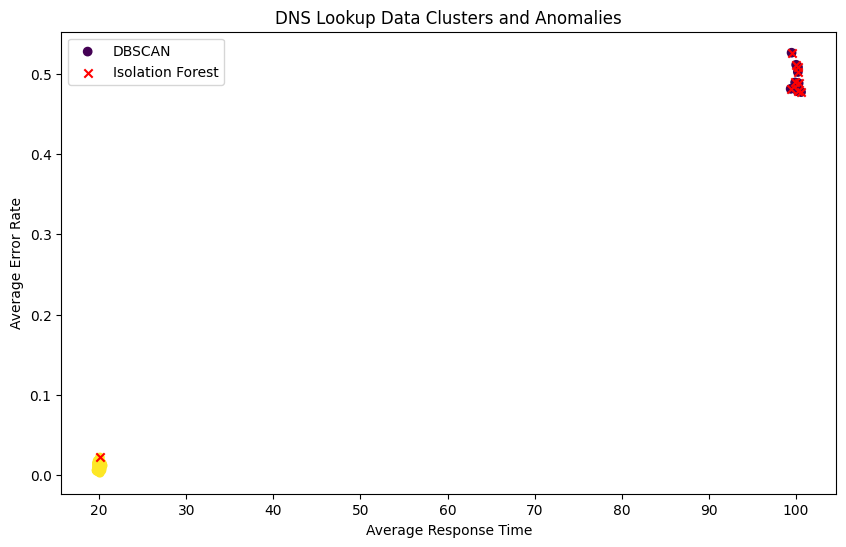

In [3]:
# Analyze results from alternative methods

# DBSCAN Analysis
print("\nDBSCAN Analysis:")
for cluster_id in set(dbscan_labels):
    if cluster_id != -1:  # -1 represents noise points
        cluster_data = data_agg[data_agg['dbscan_cluster'] == cluster_id]
        print(f"DBSCAN Cluster {cluster_id}:")
        print(" - Average Response Time:", cluster_data['response_time'].mean())
        print(" - Average Error Rate:", cluster_data['error_rate'].mean())
        print(" - Number of Domains:", len(cluster_data))

# Isolation Forest Analysis
print("\nIsolation Forest Analysis:")
anomalies_if = data_agg[isolation_forest_scores == -1]  # -1 indicates anomalies
print(" - Number of Anomalies (Isolation Forest):", len(anomalies_if))
print(" - Average Response Time (Anomalies):", anomalies_if['response_time'].mean())
print(" - Average Error Rate (Anomalies):", anomalies_if['error_rate'].mean())

# Compare and Contrast Results
# - Compare the number of clusters identified by K-Means and DBSCAN.
# - Compare the identified anomalies from K-Means, DBSCAN, and Isolation Forest.
# - Investigate the overlap and differences between the identified anomalies.
# - Visualize the results of different methods (e.g., scatter plots with different colors for each cluster/anomaly label).

# Example Visualization
plt.figure(figsize=(10, 6))
plt.scatter(data_agg['response_time'], data_agg['error_rate'],
            c=dbscan_labels, cmap='viridis', label='DBSCAN')
plt.scatter(anomalies_if['response_time'], anomalies_if['error_rate'],
            c='red', marker='x', label='Isolation Forest')
plt.xlabel('Average Response Time')
plt.ylabel('Average Error Rate')
plt.title('DNS Lookup Data Clusters and Anomalies')
plt.legend()
plt.show()

In [11]:
import numpy as np
import pandas as pd

# 1. Synthetic Data Generation with additional columns

num_records = 1000
customer_names = ['Customer' + str(i) for i in range(1, num_records // 10 + 1)] * 10
dc_list = ['DC1', 'DC2', 'DC3']
dnn_list = ['DNN1', 'DNN2', 'DNN3']
gtpc_ip_list = ['10.0.0.' + str(i) for i in range(1, 256)]
gtpu_ip_list = ['192.168.0.' + str(i) for i in range(1, 256)]
imsi_list = ['123456' + str(i) for i in range(num_records)]

# Generate random data for additional columns
errs = np.random.randint(0, 5, num_records)
primary_dns_response_time = np.random.randint(10, 50, num_records)  # Normal response times
secondary_dns_response_time = np.random.randint(15, 60, num_records)
pk_loss = np.random.uniform(0, 0.05, num_records)  # Packet loss between 0 and 5%
avg_latency = np.random.uniform(10, 100, num_records)

# Introduce anomalies in some data points
anomaly_fraction = 0.1  # 10% of data will have anomalies
anomaly_indices = np.random.choice(range(num_records), int(num_records * anomaly_fraction), replace=False)

errs[anomaly_indices] = np.random.randint(5, 20)  # Increase errors for anomalies
primary_dns_response_time[anomaly_indices] = np.random.randint(100, 500)  # Increase response time for anomalies
secondary_dns_response_time[anomaly_indices] = np.random.randint(100, 500)
pk_loss[anomaly_indices] = np.random.uniform(0.1, 0.5, len(anomaly_indices))  # Increase packet loss for anomalies
avg_latency[anomaly_indices] = np.random.uniform(200, 500, len(anomaly_indices))  # Increase latency for anomalies

# Create DataFrame
data = pd.DataFrame({
    'CustomerName': customer_names,
    'Dc': np.random.choice(dc_list, num_records),
    'Dnn': np.random.choice(dnn_list, num_records),
    'GtpcIp': np.random.choice(gtpc_ip_list, num_records),
    'GtpuIp': np.random.choice(gtpu_ip_list, num_records),
    'Imsi': imsi_list,
    'errs': errs,
    'primary_dns_response_time': primary_dns_response_time,
    'secondary_dns_response_time': secondary_dns_response_time,
    'pk_loss': pk_loss,
    'avg': avg_latency
})

data

# Save the generated data to a CSV file
data.to_csv('synthetic_dns_data.csv', index=False)


print("Synthetic data generated and saved to 'synthetic_dns_data.csv'")

Synthetic data generated and saved to 'synthetic_dns_data.csv'


In [12]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# --- Data Generation (as provided) ---

num_records = 1000
customer_names = ['Customer' + str(i) for i in range(1, num_records // 10 + 1)] * 10
dc_list = ['DC1', 'DC2', 'DC3']
dnn_list = ['DNN1', 'DNN2', 'DNN3']
gtpc_ip_list = ['10.0.0.' + str(i) for i in range(1, 256)]
gtpu_ip_list = ['192.168.0.' + str(i) for i in range(1, 256)]
imsi_list = ['123456' + str(i) for i in range(num_records)]

errs = np.random.randint(0, 5, num_records)
primary_dns_response_time = np.random.randint(10, 50, num_records)  # Normal response times
secondary_dns_response_time = np.random.randint(15, 60, num_records)
pk_loss = np.random.uniform(0, 0.05, num_records)  # Packet loss between 0 and 5%
avg_latency = np.random.uniform(10, 100, num_records)

anomaly_fraction = 0.1  # 10% of data will have anomalies
anomaly_indices = np.random.choice(range(num_records), int(num_records * anomaly_fraction), replace=False)

errs[anomaly_indices] = np.random.randint(5, 20)  # Increase errors for anomalies
primary_dns_response_time[anomaly_indices] = np.random.randint(100, 500)  # Increase response time for anomalies
secondary_dns_response_time[anomaly_indices] = np.random.randint(100, 500)
pk_loss[anomaly_indices] = np.random.uniform(0.1, 0.5, len(anomaly_indices))  # Increase packet loss for anomalies
avg_latency[anomaly_indices] = np.random.uniform(200, 500, len(anomaly_indices))  # Increase latency for anomalies

data = pd.DataFrame({
    'CustomerName': customer_names,
    'Dc': np.random.choice(dc_list, num_records),
    'Dnn': np.random.choice(dnn_list, num_records),
    'GtpcIp': np.random.choice(gtpc_ip_list, num_records),
    'GtpuIp': np.random.choice(gtpu_ip_list, num_records),
    'Imsi': imsi_list,
    'errs': errs,
    'primary_dns_response_time': primary_dns_response_time,
    'secondary_dns_response_time': secondary_dns_response_time,
    'pk_loss': pk_loss,
    'avg': avg_latency
})

# --- K-Means Clustering ---

# Select relevant features for clustering
features = ['primary_dns_response_time', 'secondary_dns_response_time', 'errs', 'pk_loss', 'avg']
X = data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters (using Elbow method - optional)
# ... (Code for Elbow method to find optimal 'k') ...

# Choose the number of clusters (e.g., 3)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# Add cluster labels to the original DataFrame
data['cluster'] = kmeans.labels_

# --- Anomaly Detection ---

# Calculate cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate distances of each data point to its cluster center
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# Define a threshold for anomaly detection (e.g., based on distance from cluster center)
threshold = np.percentile(distances, 95)  # Consider top 5% of distances as anomalies

# Identify anomalies
anomalies = data[distances > threshold]

# --- Output Results ---

print(f"Number of Anomalies: {len(anomalies)}")
print("Anomalies:")
print(anomalies)

# --- Visualization (Optional) ---
# ... (Visualize data points, clusters, and anomalies) ...

Number of Anomalies: 50
Anomalies:
    CustomerName   Dc   Dnn      GtpcIp         GtpuIp       Imsi  errs  \
5      Customer6  DC2  DNN1  10.0.0.103  192.168.0.142    1234565     7   
8      Customer9  DC3  DNN1  10.0.0.172   192.168.0.43    1234568     7   
38    Customer39  DC2  DNN1   10.0.0.19  192.168.0.236   12345638     7   
47    Customer48  DC3  DNN2  10.0.0.152  192.168.0.131   12345647     7   
64    Customer65  DC2  DNN1  10.0.0.173   192.168.0.92   12345664     7   
114   Customer15  DC2  DNN1   10.0.0.37  192.168.0.250  123456114     7   
118   Customer19  DC2  DNN3  10.0.0.133  192.168.0.195  123456118     7   
127   Customer28  DC2  DNN1  10.0.0.153   192.168.0.56  123456127     7   
129   Customer30  DC3  DNN3   10.0.0.87  192.168.0.212  123456129     7   
144   Customer45  DC2  DNN3  10.0.0.146  192.168.0.104  123456144     7   
157   Customer58  DC1  DNN2  10.0.0.139  192.168.0.127  123456157     7   
169   Customer70  DC2  DNN3   10.0.0.48   192.168.0.79  123456169

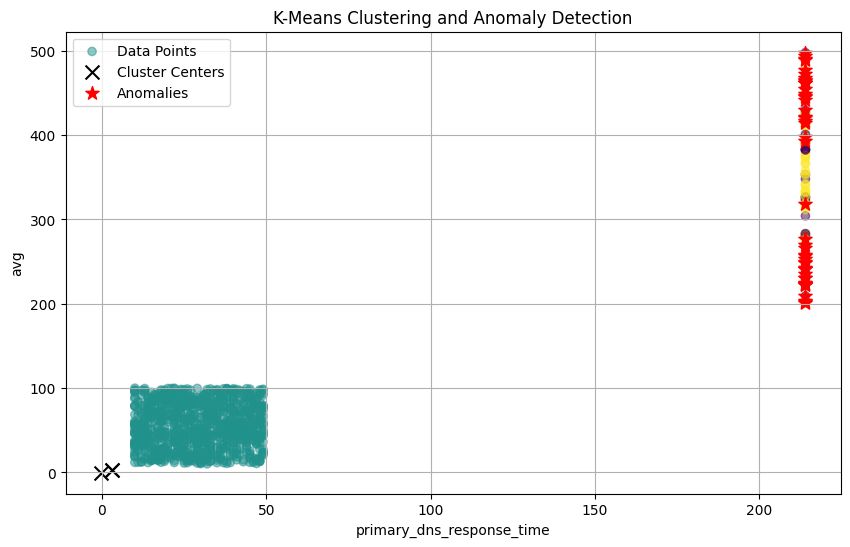

In [13]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Data Generation (as provided) ---

num_records = 1000
customer_names = ['Customer' + str(i) for i in range(1, num_records // 10 + 1)] * 10
dc_list = ['DC1', 'DC2', 'DC3']
dnn_list = ['DNN1', 'DNN2', 'DNN3']
gtpc_ip_list = ['10.0.0.' + str(i) for i in range(1, 256)]
gtpu_ip_list = ['192.168.0.' + str(i) for i in range(1, 256)]
imsi_list = ['123456' + str(i) for i in range(num_records)]

errs = np.random.randint(0, 5, num_records)
primary_dns_response_time = np.random.randint(10, 50, num_records)  # Normal response times
secondary_dns_response_time = np.random.randint(15, 60, num_records)
pk_loss = np.random.uniform(0, 0.05, num_records)  # Packet loss between 0 and 5%
avg_latency = np.random.uniform(10, 100, num_records)

anomaly_fraction = 0.1  # 10% of data will have anomalies
anomaly_indices = np.random.choice(range(num_records), int(num_records * anomaly_fraction), replace=False)

errs[anomaly_indices] = np.random.randint(5, 20)  # Increase errors for anomalies
primary_dns_response_time[anomaly_indices] = np.random.randint(100, 500)  # Increase response time for anomalies
secondary_dns_response_time[anomaly_indices] = np.random.randint(100, 500)
pk_loss[anomaly_indices] = np.random.uniform(0.1, 0.5, len(anomaly_indices))  # Increase packet loss for anomalies
avg_latency[anomaly_indices] = np.random.uniform(200, 500, len(anomaly_indices))  # Increase latency for anomalies

data = pd.DataFrame({
    'CustomerName': customer_names,
    'Dc': np.random.choice(dc_list, num_records),
    'Dnn': np.random.choice(dnn_list, num_records),
    'GtpcIp': np.random.choice(gtpc_ip_list, num_records),
    'GtpuIp': np.random.choice(gtpu_ip_list, num_records),
    'Imsi': imsi_list,
    'errs': errs,
    'primary_dns_response_time': primary_dns_response_time,
    'secondary_dns_response_time': secondary_dns_response_time,
    'pk_loss': pk_loss,
    'avg': avg_latency
})

# --- K-Means Clustering ---

# Select relevant features for clustering
features = ['primary_dns_response_time', 'secondary_dns_response_time', 'errs', 'pk_loss', 'avg']
X = data[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose the number of clusters (e.g., 3)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# Add cluster labels to the original DataFrame
data['cluster'] = kmeans.labels_

# --- Anomaly Detection ---

# Calculate cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate distances of each data point to its cluster center
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)

# Define a threshold for anomaly detection (e.g., based on distance from cluster center)
threshold = np.percentile(distances, 95)  # Consider top 5% of distances as anomalies

# Identify anomalies
anomalies = data[distances > threshold]

# --- Visualization ---

import matplotlib.pyplot as plt

# Select two features for visualization (e.g., 'primary_dns_response_time' and 'avg')
x_axis = 'primary_dns_response_time'
y_axis = 'avg'

plt.figure(figsize=(10, 6))

# Plot all data points
plt.scatter(data[x_axis], data[y_axis], c=kmeans.labels_, cmap='viridis', alpha=0.5, label='Data Points')

# Plot cluster centers
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=100, c='black', label='Cluster Centers')

# Plot anomalies
plt.scatter(anomalies[x_axis], anomalies[y_axis], c='red', marker='*', s=100, label='Anomalies')

plt.xlabel(x_axis)
plt.ylabel(y_axis)
plt.title("K-Means Clustering and Anomaly Detection")
plt.legend()
plt.grid(True)
plt.show()